In [1]:
DIM = 4
SIZE = DIM ** 2


domain = list(range(0, SIZE))
domain_num = list(range(1, SIZE + 1))
spots = [(i, j) for i in domain for j in domain]


peers = {} 
for spot in spots:
    i, j = spot
    
    # get row and column peers
    peers[spot] = [(i,c) for c in domain if c!=j] + \
                  [(r,j) for r in domain if r!=i]

    # upper-left coordinate of the square unit
    ul_i = (i//DIM)*DIM
    ul_j = (j//DIM)*DIM

    # get square peers
    for rr in range(DIM):
        for cr in range(DIM):
            peer_spot = (ul_i+rr, ul_j+cr)
            if peer_spot != spot:
                peers[spot].append(peer_spot)
                

In [2]:
len(spots)

256

In [3]:
import copy

In [17]:
# sd_peers contains all the peers for any spot locations
#    peers = all positions in column, row and subgrid

def init_domains():
    domains = {}
    for i, j in spots:
        domains[(i, j)] = [k for k in domain_num]
    return domains

def restrict_domain(domains, problem):
    for i, j in spots:
        c = problem[i*SIZE+j] 
        if c != '.':
            domains[(i, j)] = [c]
            
def init_assignment(domains):
    assignment = {}
    for spot in spots:
        if len(domains[spot]) == 1:
            assignment[spot] = domains[spot]
    
    return assignment


# display function
def check_draw_delim(ind):
    return ((ind + 1) != SIZE) and ((ind + 1) % DIM == 0)

def display(domains):
    for i in domain:
        for j in domain:
            d = domains[(i,j)]
            if len(d) == 1:
                print(d[0], end='')
            else: 
                print('.', end='')
            if check_draw_delim(j):
                print(" | ", end='')
        print()
        if check_draw_delim(i):
            print("-" * (DIM * DIM + 3 * (DIM - 1)))

In [18]:
def has_conflict(domains):
    for spot in spots:
        if len(domains[spot]) == 0:
            return True
        
    return False


def is_peer(pos1, pos2):
    return pos2 in peers[pos1]


def backtrack(decision_stack):
    assignment, domains, decision = decision_stack.pop()
    a = assignment[decision][0]
    domains[decision].remove(a)
    assignment.pop(decision)
    return assignment, domains

def make_decision(assignment, domains):
    decision = None
    for spot in spots:
        if spot not in assignment:
            decision = spot
            break
    assignment[decision] = [domains[decision][0]]
    domains[decision] = assignment[decision]
    return assignment, decision


def propagate(assignment, domains):
    while True:
        for spot in spots:
            if spot not in assignment and len(domains[spot]) == 1:
                assignment[spot] = domains[spot]
        
        for spot in spots:
            if spot in assignment and len(domains[spot]) > 1:
                domains[spot] = assignment[spot]
        
        if has_conflict(domains):
            return assignment, domains
        
        # update domains with naked singles
        exists = False
        for pos1 in spots:
            for pos2 in spots:
                if pos1 == pos2:
                    continue
                
                if len(domains[pos1]) == 1 and is_peer(pos1, pos2) and domains[pos1][0] in domains[pos2]:
                    domains[pos2].remove(domains[pos1][0])
                    exists = True
        
        # no naked single updates in this while iteration
        if not exists:
            break
        
    return assignment, domains

def backtracking_with_pruning(problem):
    domains = init_domains()
    restrict_domain(domains, problem)
    
    assignment = init_assignment(domains)
    decision_stack = []
    
    while True: 
        assignment, domains = propagate(copy.deepcopy(assignment), copy.deepcopy(domains))
        
        if has_conflict(domains):
            if len(decision_stack) == 0:
                return None
            assignment, domains = backtrack(decision_stack)
        
        else:
            if len(assignment) == len(spots): # every spot has assignment
                return assignment
        
            assignment, decision = make_decision(copy.deepcopy(assignment), copy.deepcopy(domains))
            decision_stack.append((assignment, domains, decision))
    

In [ ]:
import os
import time
import matplotlib.pyplot as plt

input_dir = "./"
solve = backtracking_with_pruning  # Ensure this function is defined

# Store results for plotting
data_points = []

# Process each problem_xxx.txt file
for file_name in sorted(os.listdir(input_dir)):
    if file_name.startswith("problem_") and file_name.endswith(".txt"):
        file_path = os.path.join(input_dir, file_name)

        # Extract the number of cells removed from the filename
        try:
            num_cells_removed = int(file_name[8:-4])  # Extract number from "problem_XXX.txt"
        except ValueError:
            continue  # Skip files with unexpected naming format

        # Read all puzzles from the file
        with open(file_path, "r", encoding="utf-8") as f:
            problems = f.read().splitlines()

        # Measure execution time for each puzzle
        total_time = 0
        num_problems = len(problems)

        for problem in problems:
            start_time = time.time()
            assignment = solve(problem)  # Call the solver function
            end_time = time.time()
            print(assignment != None)
            total_time += (end_time - start_time)

        # Compute and store the average runtime
        if num_problems > 0:
            avg_time = total_time / num_problems
            print(f"File: {file_name}, Average Runtime: {avg_time:.6f} seconds per puzzle")
            data_points.append((num_cells_removed, avg_time))  # Store (X, Y) pair

In [ ]:
# Save results to a file
output_file = "runtime_results.txt"
with open(output_file, "w", encoding="utf-8") as f:
    for num_cells_removed, avg_time in data_points:
        f.write(f"{num_cells_removed} {avg_time:.6f}\n")

print(f"Results saved to {output_file}")

# Sort data points by number of cells removed for plotting
data_points.sort()

# Extract X (number of cells removed) and Y (average runtime)
x_values, y_values = zip(*data_points)

# Plotting the data
plt.figure(figsize=(8, 5))
plt.plot(x_values, y_values, marker="o", linestyle="-", color="b", label="Avg. Runtime")

plt.xlabel("Number of Cells Removed")
plt.ylabel("Average Runtime (seconds)")
plt.title("Sudoku Solver Performance")
plt.legend()
plt.grid(True)

# Save the plot
plt.savefig("runtime_plot_with_pruning.png")
plt.show()

In [ ]:
def backtracking_without_pruning(problem):
    domains = init_domains()
    restrict_domain(domains, problem)
    
    assignment = init_assignment(domains)
    decision_stack = []
    
    while True: 
        # no propagate with eliminating naked singles
        assignment, domains = copy.deepcopy(assignment), copy.deepcopy(domains)
        
        if has_conflict(domains):
            if len(decision_stack) == 0:
                return None
            assignment, domains = backtrack(decision_stack)
        
        else:
            if len(assignment) == len(spots): # every spot has assignment
                return assignment
        
            assignment, decision = make_decision(copy.deepcopy(assignment), copy.deepcopy(domains))
            decision_stack.append((assignment, domains, decision))

In [13]:
import os
import time
import matplotlib.pyplot as plt

input_dir = "./"
solve = backtracking_without_pruning  # Ensure this function is defined

# Store results for plotting
data_points_pure = []

# Process each problem_xxx.txt file
for file_name in sorted(os.listdir(input_dir)):
    if file_name.startswith("problem_") and file_name.endswith(".txt"):
        file_path = os.path.join(input_dir, file_name)

        # Extract the number of cells removed from the filename
        try:
            num_cells_removed = int(file_name[8:-4])  # Extract number from "problem_XXX.txt"
        except ValueError:
            continue  # Skip files with unexpected naming format

        # Read all puzzles from the file
        with open(file_path, "r", encoding="utf-8") as f:
            problems = f.read().splitlines()

        # Measure execution time for each puzzle
        total_time = 0
        num_problems = len(problems)

        for problem in problems:
            start_time = time.time()
            assignment = solve(problem)  # Call the solver function
            end_time = time.time()
            print(assignment != None)
            total_time += (end_time - start_time)

        # Compute and store the average runtime
        if num_problems > 0:
            avg_time = total_time / num_problems
            print(f"File: {file_name}, Average Runtime: {avg_time:.6f} seconds per puzzle")
            data_points_pure.append((num_cells_removed, avg_time))  # Store (X, Y) pair

True
True
True
True
True
File: problem_100.txt, Average Runtime: 0.843532 seconds per puzzle
True
True
True
True
True
File: problem_120.txt, Average Runtime: 0.734000 seconds per puzzle
True
True
True
True
True
File: problem_140.txt, Average Runtime: 0.588685 seconds per puzzle
True
True
True
True
True
File: problem_200.txt, Average Runtime: 0.251876 seconds per puzzle
True
True
True
True
True
File: problem_220.txt, Average Runtime: 0.163514 seconds per puzzle


Results saved to runtime_results_without_prunning.txt


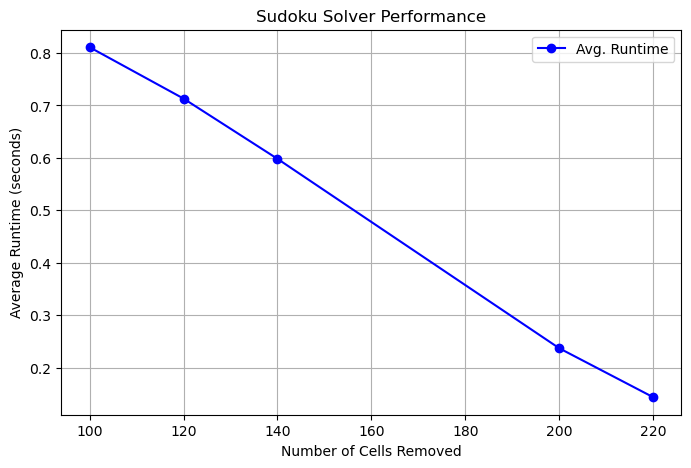

In [11]:
# Save results to a file
output_file = "runtime_results_without_prunning.txt"
with open(output_file, "w", encoding="utf-8") as f:
    for num_cells_removed, avg_time in data_points_pure:
        f.write(f"{num_cells_removed} {avg_time:.6f}\n")

print(f"Results saved to {output_file}")

# Sort data points by number of cells removed for plotting
data_points_pure.sort()

# Extract X (number of cells removed) and Y (average runtime)
x_values, y_values = zip(*data_points_pure)

# Plotting the data
plt.figure(figsize=(8, 5))
plt.plot(x_values, y_values, marker="o", linestyle="-", color="b", label="Avg. Runtime")

plt.xlabel("Number of Cells Removed")
plt.ylabel("Average Runtime (seconds)")
plt.title("Sudoku Solver Performance")
plt.legend()
plt.grid(True)

# Save the plot
plt.savefig("runtime_plot_without_prunning.png")
plt.show()